# Import Review Scores

### 23rd July 2014 Neil D. Lawrence

This notebook imports review scores from CMT for analysis. In particular it does some quality checks on correlation, and on review length. It was first used for exploring the status of the reviews and what areas may need to be addressed. This led to the creation of Attention Reports which were emailed to area chairs and highlighted particular issues. Those attention reports can be found 

In [2]:
import cmtutils as cu
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10., 8.)
plt.rcParams['font.size'] = 16

filename = '2014-07-23_paper_list.xls'
papers = cu.CMT_Papers_read(filename=filename)
filename = '2014-07-24_reviews.xls'
reviews = cu.CMT_Reviews_read(filename=filename)

## Duplicate Papers Correlation

For NIPS 2014 we experimented with duplicate papers: we pushed papers through the system twice, exposing them to different subsets of the reviewers. The first thing we'll look at is the duplicate papers. Firstly we identify them by matching on title.

In [3]:
duplicate_list = []
for ID, title in papers.papers.Title.iteritems():
    if int(ID)>1779 and int(ID) != 1949:
        pair = list(papers.papers[papers.papers['Title'].str.contains(papers.papers.Title[ID].strip())].index)
        pair.sort(key=int)
        duplicate_list.append(pair)

Next we compute the correlation coefficients for the duplicated papers for the average impact and quality scores.

In [4]:

quality = []
impact = []
confidence = []
for duplicate_pair in duplicate_list:
    quality.append([np.mean(reviews.reviews.loc[duplicate_pair[0]].Quality), np.mean(reviews.reviews.loc[duplicate_pair[1]].Quality)])
    impact.append([np.mean(reviews.reviews.loc[duplicate_pair[0]].Impact), np.mean(reviews.reviews.loc[duplicate_pair[1]].Impact)])
    confidence.append([np.mean(reviews.reviews.loc[duplicate_pair[0]].Conf), np.mean(reviews.reviews.loc[duplicate_pair[1]].Conf)])
quality = np.array(quality)
impact = np.array(impact)
confidence = np.array(confidence)
quality_cor = np.corrcoef(quality.T)[0, 1]
impact_cor = np.corrcoef(impact.T)[0, 1]
confidence_cor = np.corrcoef(confidence.T)[0, 1]
print("Quality correlation: ", quality_cor)
print("Impact correlation: ", impact_cor)
print("Confidence correlation: ", confidence_cor)

Quality correlation:  0.5549732817306531
Impact correlation:  0.20325670838313706
Confidence correlation:  0.39636631681408674


## Quality Scatter Plot

To visualize the quality score correlation we plot the group 1 papers against the group 2 papers. Here we add a small amount of jitter to ensure points to help visualize points that would otherwise fall on the same position. 

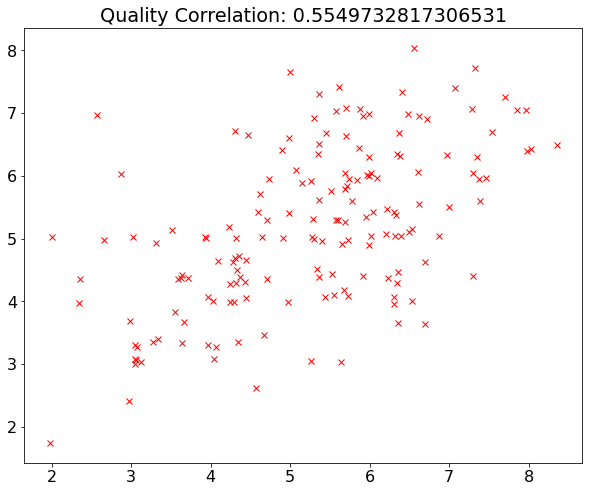

In [5]:
plt.plot(quality[:, 0]+np.random.randn(quality.shape[0])*0.06125, quality[:, 1]+np.random.randn(quality.shape[0])*0.06125, 'rx')
_ = plt.title('Quality Correlation: ' + str(quality_cor))

## Impact Scatter Plot

Similar for the impact score.

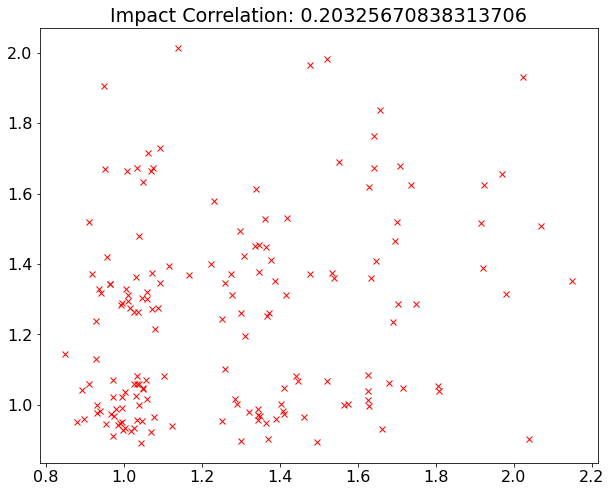

In [6]:
plt.plot(impact[:, 0]+np.random.randn(impact.shape[0])*0.06125, impact[:, 1]+np.random.randn(impact.shape[0])*0.06125, 'rx')
_ = plt.title('Impact Correlation: ' + str(impact_cor))

## Confidence Correlation Score

Correlation of confidence between the two duplicates.

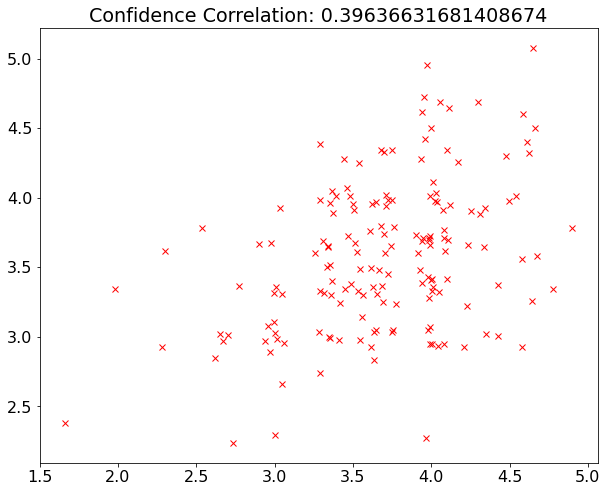

In [7]:
plt.plot(confidence[:, 0]+np.random.randn(confidence.shape[0])*0.06125, confidence[:, 1]+np.random.randn(confidence.shape[0])*0.06125, 'rx')
_ = plt.title('Confidence Correlation: ' + str(confidence_cor))

## Quality Score

The main score people are familiar with for NIPS, the quality score, ranging from 1 to 10. A paper with 6 or above is *recommended* for accept. Here we plot a histogram of individual review quality scores for the whole conference.

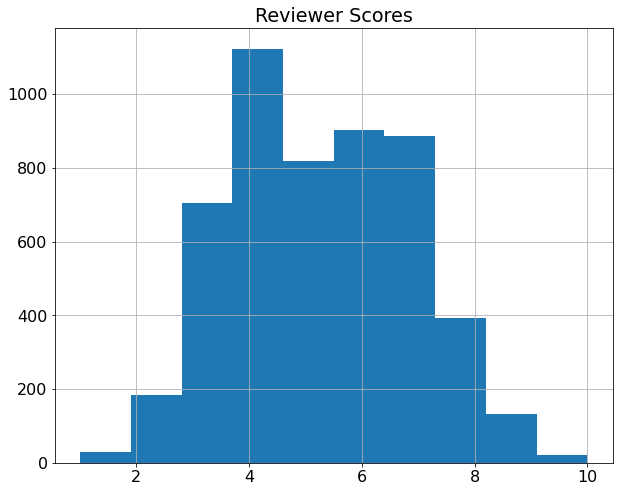

In [8]:
reviews.reviews.Quality.hist(bins=10, range=(1, 10))
_ = plt.title('Reviewer Scores')

### Span of Quality Score

Another question of interest is what is the typical 'span' of quality scores, i.e. how consistent are the reviews (we could also measure this by variance, but span gives us the maximum score minus the minimum which gives a sensible integer value. If a paper has a very large span, it may need attention from the are chair. First we need to compute this for each paper.

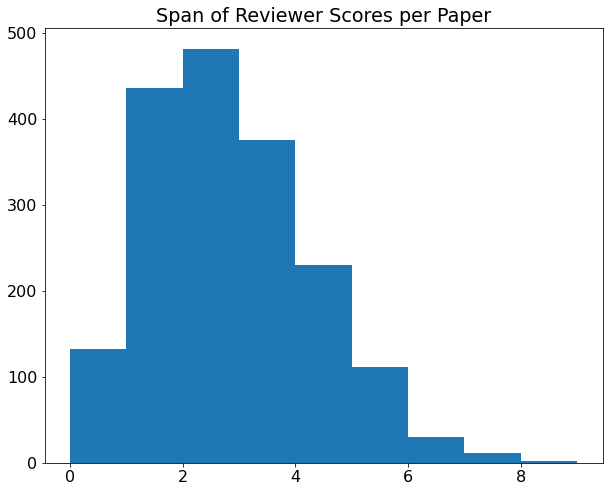

In [9]:
span = []
for paper in sorted(set(reviews.reviews.index), key = int):
    span.append(np.max(reviews.reviews.loc[paper].Quality) 
                - np.min(reviews.reviews.loc[paper].Quality))
span = np.array(span)
plt.hist(span, bins = np.max(span)-np.min(span)+1, range=(np.min(span),np.max(span)+1))
_ = plt.title('Span of Reviewer Scores per Paper')

## Impact

Impact score is either 1 or 2. This was an innovation introduced by Zoubin and Max to try and help identify papers that were likely to have an influence (independently of their technical qualities). Let's see how often a paper is scored as high impact.

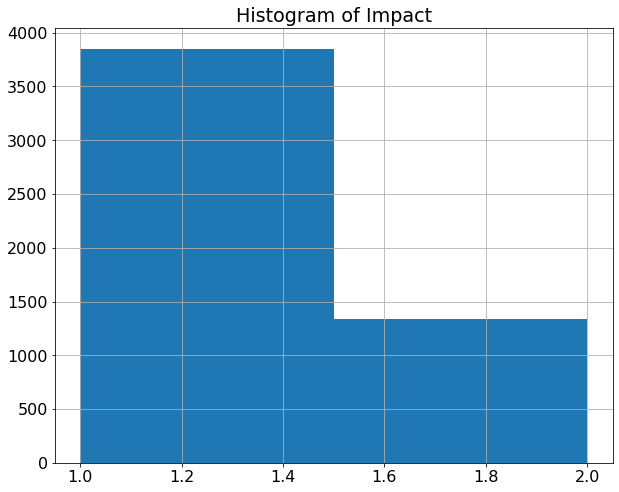

In [10]:
reviews.reviews.Impact.hist(bins=2, range=(1, 2))
_ = plt.title('Histogram of Impact')

## Confidence Score

Confidence scores vary from 1 to 5. Low confidence scores *may* indicate a inappropriate reviewer allocation, but just as often they'll indicate a poorly written paper or a paper that isn't really appropriate for the NIPS community. By investigating confidence scores we can determine papers that may need attention.

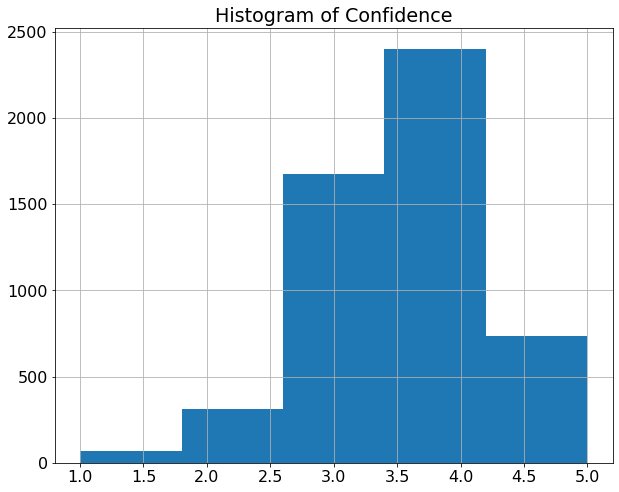

In [11]:
reviews.reviews.Conf.hist(bins=5, range=(1, 5))
_ = plt.title('Histogram of Confidence')

## Length of Reviews

Another concern could be very short reviews. Let's have a look at review length for the conference reviews.

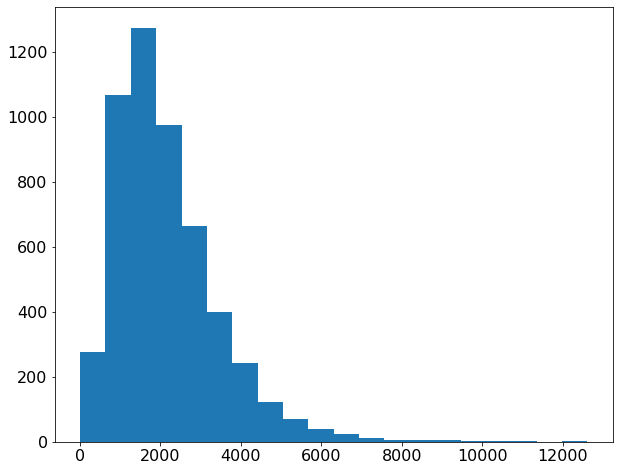

In [12]:
comment_len = []
for paper, comments in reviews.reviews.Comments.iteritems():
    comment_len.append(len(comments))
comment_len = np.array(comment_len)
_ = plt.hist(comment_len,bins=20)

This script goes through reviews and prints those which are less than 200 characters long. These may need addressing by alerting the area chair or prompting the reviewer to provide more detailed comments.

In [ ]:
for index, review in reviews.reviews.loc[(comment_len<200)].iterrows():
    #print(index, review['Email'], review['Comments'])
    print(index, review['Comments'])
#plt.plot(comment_len, reviews.reviews.Quality, 'rx')

In [14]:
comments_len = pd.Series(comment_len, index=reviews.reviews.index)

There is one paper with a comment length of over 12000 characters. That's quite long. Let's also have a look at that.

,Quality,Impact
ID,,
1582,6,1


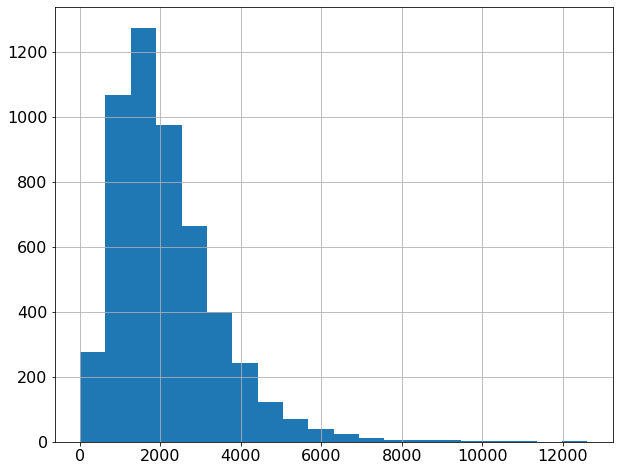

In [15]:
comments_len.hist(bins=20)
#reviews.reviews.loc[comments_len>12000][['Quality', 'Impact', 'Email']]

reviews.reviews.loc[comments_len>12000][['Quality', 'Impact']]

In [ ]:
for index, review in reviews.reviews.loc[(comment_len>12000)].iterrows():
    #print(index, review['Email'], review['Comments'])
    print(index, review['Comments'])